## Let's run intron clustering to annotate alternative splicing events given observed junctions in our cells 

In [9]:
# Load LeafletSC 
import LeafletSC
import os
import pandas as pd 

# Define path that contains some junction files (only 2 files are used for this example, corresponding to 2 individual cells)
juncs_path = "/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/"
print("The junctions are loaded from the following path: " + juncs_path) 

# print the files in the path 
print("The files in the path are: " + str(os.listdir(juncs_path)))

# define path for saving the output data 
output_path = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/"

The junctions are loaded from the following path: /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/
The files in the path are: ['B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM.juncswbarcodes', 'B107925_B5_S284.homo.gencode.v30.ERCC.chrM.juncswbarcodes']


### Let's first define some parameters for the analysis

In [2]:
from LeafletSC.clustering.obtain_intron_clusters import main as obtain_intron_clusters
from LeafletSC.clustering.prep_model_input import main as prep_model_input

# junc_files defines a path for where junction files can be found, in this case, the path is defined above
junc_files = juncs_path

# we provide a gtf file for the human genome as well to make better sense of the junctions that are detected in cells
# please replace with the path to the gtf file on your system
gtf_file="/gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf" 

# define additional parameters 
sequencing_type = "single_cell"

# ensure output files are to be saved in output_path 
output_file = output_path + "test_intron_clusters"
junc_bed_file= output_path + "test_juncs.bed" # you can load this file into IGV to visualize the junction coordinates 
min_intron_length = 50
max_intron_length = 500000
threshold_inc = 0.05 
min_junc_reads = 2
min_num_cells_wjunc = 2
keep_singletons = False # ignore junctions that do not share splice sites with any other junction (likely const)
junc_suffix = "*.juncswbarcodes" # depends on how you ran regtools 

### Run intron clustering 

In [3]:
obtain_intron_clusters(junc_files=junc_files, gtf_file=gtf_file, output_file=output_file, 
                       sequencing_type=sequencing_type, junc_bed_file=junc_bed_file, 
                       threshold_inc=threshold_inc, min_intron = min_intron_length,
                       max_intron=max_intron_length, min_junc_reads=min_junc_reads,
                       singleton=keep_singletons, strict_filter=False, 
                       junc_suffix=junc_suffix, min_num_cells_wjunc=min_num_cells_wjunc,
                       filter_low_juncratios_inclust=False)

Reading in junction files from /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions
The number of regtools junction files to be processed is 2


100%|██████████| 2/2 [00:00<00:00, 12.48it/s]


The total number of files that could not be read is 0 as these had no junctions
The gtf file you provided is /gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf
Now reading gtf file using gtfparse
This step may take a while depending on the size of your gtf file


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


Reading gtf file took 45.91 seconds
The number of unique exons is 411865
The number of unique transcript ids is 115526
The number of unique gene ids is 62668
Done extracting exons from gtf file
Loading files obtained from single_cell sequencing
Filtering based on intron length
Cleaning up 'chrom' column
Making gr object from all junctions across all cell types
The summary statistics for counts_total across junctions are: 
count    14417.000000
mean       167.274745
std        496.475133
min          1.000000
25%         15.000000
50%         70.000000
75%        172.000000
max      17913.000000
Name: counts_total, dtype: float64
The number of junctions with only 1 read across the board is: 
1007
The number of junctions after filtering for minimum junction reads is 12876
The number of junctions prior to assessing distance to exons is 12876
Annotating junctions with known exons based on input gtf file
The number of junctions after assessing distance to exons is 11813
Clustering intron sp

### Now let's convert the intron clusters to a format that can be used by LeafletSC )

In [7]:
intron_clusters = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/test_intron_clusters_50_500000_2_20240309_single_cell.gz" # path to the intron clusters file
output_file = output_path + "test_model_input" # name of the output file
has_genes = "yes" # since we used a gtf file to obtain the intron clusters, we can set this to yes
chunk_size = 5000 # number of junctions to process at a time from the intron clusters files
metadata = None # can replace with path, if metadata is available for cells (cell type, origin, library ID...)

In [8]:
prep_model_input.main(intron_clusters, output_file, has_genes, chunk_size, metadata)

The intron clusters file you provided is /gpfs/commons/home/kisaev/LeafletSC/data/processed/test_intron_clusters_50_500000_2_20240309_single_cell.gz, reading in chunks of 5000 lines
Processing intron clusters


1it [00:00, 52.99it/s]

Done processing intron clusters
The number of intron clusters evaluated is 237
The number of junctions evaluated is 694
The number of cells evaluated is 2
The number of clusters with only one junction is 0
A gtf file was used to generate intron clusters
The number of total cells evaluated is 2
The number of cells per cell type is:
cell_type
/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/B107925_B5_S284.homo.gencode.v30.ERCC.chrM.juncswbarcodes               1
/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM.juncswbarcodes    1
Name: cell_type, dtype: int64
['B107925_B5_S284.homo.gencode.v30.ERCC.chrM_/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/B107925_B5_S284.homo.gencode.v30.ERCC.chrM.juncswbarcodes'
 'B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM_/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM.juncswbarcodes']
You can find the resulting f

### Take a quick look at the input file that will go into the model to get familiarized with all the columns

In [10]:
model_input_data = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/test_model_input.h5"
summarized_data = pd.read_hdf(model_input_data, 'df')
print(summarized_data.head())

                                             cell_id  Cluster  Cluster_Counts  \
0  B107925_B5_S284.homo.gencode.v30.ERCC.chrM_/gp...       70             153   
1  B107925_B5_S284.homo.gencode.v30.ERCC.chrM_/gp...       70             153   
2  B107925_B5_S284.homo.gencode.v30.ERCC.chrM_/gp...      151             376   
3  B107925_B5_S284.homo.gencode.v30.ERCC.chrM_/gp...      151             376   
4  B107925_B5_S284.homo.gencode.v30.ERCC.chrM_/gp...      151             376   

             junction_id             gene_id  junc_count  \
0  1_175004814_175006744  ENSG00000116161.18           8   
1  1_175004833_175006744  ENSG00000116161.18         145   
2  1_145608175_145616233  ENSG00000117262.19         218   
3  1_145608175_145618319  ENSG00000117262.19          20   
4  1_145616293_145618319  ENSG00000117262.19         138   

                                           cell_type  junc_ratio  \
0  /gpfs/commons/home/kisaev/LeafletSC/data/raw/j...    0.052288   
1  /gpfs/commons

#### Note that fow now, the values in cell_type default to the cell's path, in the future it will be possible to specify the cell type in the metadata file

In [13]:
summarized_data.cell_type.unique()

array(['/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/B107925_B5_S284.homo.gencode.v30.ERCC.chrM.juncswbarcodes',
       '/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM.juncswbarcodes'],
      dtype=object)

In [11]:
# let's see all the columns in the summarized data
print(summarized_data.columns)

Index(['cell_id', 'Cluster', 'Cluster_Counts', 'junction_id', 'gene_id',
       'junc_count', 'cell_type', 'junc_ratio', 'cell_id_index',
       'junction_id_index'],
      dtype='object')


#### We can quickly visualize the overall junction usage ratio distribution across all cells

Axes(0.125,0.11;0.775x0.77)


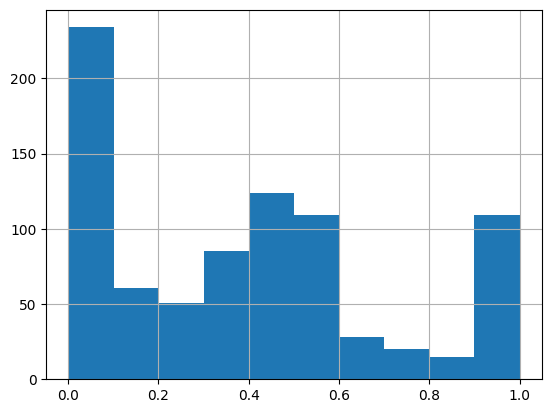

In [16]:
print(summarized_data.junc_ratio.hist())

### Now we have everything need to run the Leaflet mixture model! Please refer to the next notebook for the next steps.